## 1. Retrieving and Processing MODIS EVI Data

In [1]:
import geemap
import ee
import os
import re
import geopandas as gpd

# Authenticate to Earth Engine
ee.Authenticate()
ee.Initialize()

# Set Area of Interest (AOI) as a polygon

# Load the rice field shapefile and convert it to a GeoJSON format
rice_field_data_path = 'NAKHON RATCHASIMA_L1_2021_delgeom.geojson'
rice_field = gpd.read_file(rice_field_data_path)
rice_field = rice_field.to_crs(epsg=4326)
# Check for and filter out invalid geometries
rice_field = rice_field[rice_field['geometry'].is_valid]

# Extract the minimum and maximum x and y coordinates from the rice field GeoJSON data
min_x, min_y, max_x, max_y = rice_field.total_bounds

# Define the AOI polygon using the extracted coordinates
AOI = ee.Geometry.Polygon([
    [min_x, min_y],
    [max_x, min_y],
    [max_x, max_y],
    [min_x, max_y],
    [min_x, min_y]
])

# Define the MODIS EVI product
modis_evi = 'MODIS/061/MOD13Q1'

# Define the time range
start_date = '2023-01-01'
end_date = '2023-12-30' 

# Define a function to mask out cloudy pixels
def maskClouds(image):
    QA = image.select('SummaryQA')
    cloud = QA.bitwiseAnd(1 << 10).eq(0) 
    return image.updateMask(cloud)

# Filter the MODIS EVI collection based on the time and location
evi_collection = ee.ImageCollection(modis_evi)\
    .filterBounds(AOI)\
    .filterDate(ee.Date(start_date), ee.Date(end_date))\
    .select(['EVI', 'SummaryQA']) 

# Apply cloud masking function to the collection
evi_collection_masked = evi_collection.map(maskClouds)

# Clip the collection to the AOI
evi_collection_clipped = evi_collection_masked.map(lambda image: image.clip(AOI))


# Define output directory for exporting images
output_dir = 'SVI/evi_data'

# Use the `geemap` library to download the rescaled EVI collection as GeoTIFF images with the specified CRS
geemap.ee_export_image_collection(evi_collection_clipped, output_dir, scale=250, crs='EPSG:4326')

# Define a regular expression pattern to extract the date information from the filenames
re_pattern = re.compile(r'(\d{4})_(\d{2})_(\d{2})\.tif')

# List the exported files in the output directory
exported_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]

# Iterate through the exported files and rename them
for old_filename in exported_files:
    match = re_pattern.match(old_filename)
    if match:
        # Extract date information from the old filename
        year, month, day = match.groups()
        
        # Define the new filename format
        new_filename = f'MOD13Q1.061_250m_16_days_EVI_doy{year}{day.zfill(3)}_aid0002.tif'
        
        try:
            # Rename the file
            os.rename(os.path.join(output_dir, old_filename), os.path.join(output_dir, new_filename))
            print(f"Renamed {old_filename} to {new_filename}")  # Print renaming result
        except Exception as e:
            print(f"Error occurred while renaming {old_filename}: {e}")
    else:
        print(f"Skipping file {old_filename} as it does not match the expected format")

Total number of images: 23

Exporting 1/23: SVI/evi_data/2023_01_01.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_01_01.tif


Exporting 2/23: SVI/evi_data/2023_01_17.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_01_17.tif


Exporting 3/23: SVI/evi_data/2023_02_02.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_02_02.tif


Exporting 4/23: SVI/evi_data/2023_02_18.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom

Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_11_01.tif


Exporting 21/23: SVI/evi_data/2023_11_17.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_11_17.tif


Exporting 22/23: SVI/evi_data/2023_12_03.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_12_03.tif


Exporting 23/23: SVI/evi_data/2023_12_19.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/watcharin-p/Library/CloudStorage/OneDrive-SuranareeUniversityofTechnology/WatcharinP/GitHub/Thaicom/Assignment/solution2/SVI/evi_data/2023_12_19.tif


Renamed 2023_12_19.tif to MOD13Q1.06

## 2. Exporting Soil Vegetation Index (SVI) GeoTIFF


In [25]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
gdal.UseExceptions()

def custom_enumerate(iterator, desc=None):
    if desc is not None:
        pass
    return zip(range(1, len(iterator) + 1), iterator)

# Define a function to print and return the extent of a raster dataset
def print_extent(dataset):
    geo_transform = dataset.GetGeoTransform()
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    extent = (geo_transform[0], 
              geo_transform[0] + x_size * geo_transform[1],
              geo_transform[3] + y_size * geo_transform[5], 
              geo_transform[3])
    return extent

def get_doy(re_doy, string):
    search_doy = re_doy.search(string)
    if search_doy is None:
        return None
    doy = search_doy.group(1)
    year = int(doy[:4])
    day = doy[4:]
    return year, day

def check_prepare_files(evi_files):
    doy_dict = {}
    for path, year, day in evi_files:
        try:
            doy_dict[day]['evi'].append((path, year, day))
        except KeyError:
            doy_dict[day] = {'evi': [(path, year, day)]}
    return doy_dict

def load_evi(files_list):
    evi_data = []
    for path, _, _ in files_list:
        dataset = gdal.Open(path)
        band = dataset.GetRasterBand(1)
        data = band.ReadAsArray()
        evi_data.append(data)
    return np.array(evi_data)

def prepare_evi(evi):
    evi = evi.astype(np.float64)
    #evi[evi < 0] = np.nan
    evi[(evi < -2000) | (evi > 10000)] = np.nan
    evi = np.clip(evi, -2000, 10000)  # Clip values to ensure they are within desired range
    evi *= 0.0001
    return evi

def calculate_svi(evi):
    with np.errstate(invalid='ignore'):
        svi = (evi - np.nanmean(evi, axis=2, keepdims=True)) / np.nanstd(evi, axis=2, keepdims=True)
    return svi

def generate_geotiff_with_extent(file_name, data, geo_transform, projection, extent, output_path):
    # Create the output GeoTIFF file path
    geotiff_path = os.path.join(output_path, file_name + ".tif")

    # Get the number of rows and columns from the data array
    rows, cols = data.shape
    
    # Create the output GeoTIFF
    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(geotiff_path, cols, rows, 1, gdal.GDT_Float64)

    # Set the GeoTransform and Projection
    out_raster.SetGeoTransform(geo_transform)
    out_raster.SetProjection(projection)

    # Write the array data to the output band
    out_band = out_raster.GetRasterBand(1)
    out_band.WriteArray(data)

    # Flush the cache and close the output raster
    out_band.FlushCache()
    out_raster = None

    print(f"Generated GeoTIFF with SVI values for {file_name}")

def rearrange_svi(svi):
    # Find the maximum and minimum SVI values
    max_svi = np.max(svi)
    min_svi = np.min(svi)
    
    # Rearrange the SVI values to the range [0, 1]
    rearranged_svi = (svi - min_svi) / (max_svi - min_svi)
    
    return rearranged_svi

def export_latest_svi(evi_files_day, study_area, geo_transform, projection, extent, output_path):
    # Get the second-to-latest EVI file
    latest_evi_file = evi_files_day[-1]
    path, year, day = latest_evi_file

    # Load the EVI data
    evi = load_evi([latest_evi_file])
    evi = prepare_evi(evi)

    svi = calculate_svi(evi)

    # Rearrange SVI values to the range [0, 1]
    svi = rearrange_svi(svi)
    
    # Generate the file name for the SVI image
    file_name = f"Latest_SVI_{study_area}_{day}_{year}"

    # Export the SVI as a GeoTIFF
    generate_geotiff_with_extent(file_name, svi[0], geo_transform, projection, extent, output_path)

def main():
    study_area = "rice_field"
    path_evi = "SVI/evi_data"
    path_tif = "SVI/svi_data"
    re_doy = re.compile(r".*doy(\d{7}).*\.tif$")

    evi_files = []
    for root, _, files in os.walk(path_evi):
        for file in files:
            doy = get_doy(re_doy, file)
            if doy is not None:
                evi_files.append((os.path.join(root, file), *doy))

    if not evi_files:
        print("No EVI files found in the specified directory.")
        return

    example_file = gdal.Open(evi_files[0][0])
    geo_transform = example_file.GetGeoTransform()
    projection = example_file.GetProjection()
    x_size = example_file.RasterXSize
    y_size = example_file.RasterYSize
    extent = print_extent(example_file)

    if not os.path.exists(path_tif):
        os.makedirs(path_tif)

    doy_dict = check_prepare_files(evi_files)

    # Export SVI for the latest image only
    #latest_day = max(doy_dict.keys())
    #evi_files_day = doy_dict[latest_day]['evi']
    #export_latest_svi(evi_files_day, study_area, geo_transform, projection, extent, path_tif)

    sorted_days = sorted(doy_dict.keys())
    before_latest_day = sorted_days[-2]
    evi_files_day = doy_dict[before_latest_day]['evi']
    export_latest_svi(evi_files_day, study_area, geo_transform, projection, extent, path_tif)

if __name__ == "__main__":
    main()


Generated GeoTIFF with SVI values for Latest_SVI_rice_field_029_2023


Warning 1: SVI/evi_data/MOD13Q1.061_250m_16_days_EVI_doy2023014_aid0002.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: SVI/evi_data/MOD13Q1.061_250m_16_days_EVI_doy2023029_aid0002.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


## 3. Plot Rice Field Polygons
Below is a Python function plot_rice_field that plots rice field polygons using Matplotlib. This function takes the path to the rice field GeoJSON file as input and visualizes the polygons on a map.

EPSG:4326


/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.p

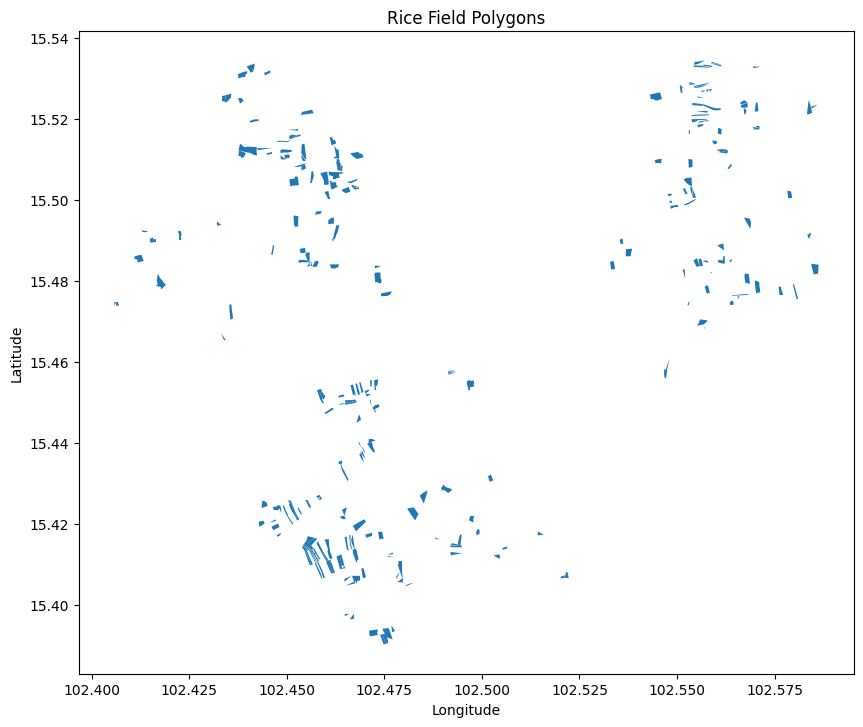

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_rice_field(rice_field_data_path):

    # Load the rice field GeoDataFrame
    rice_field = gpd.read_file(rice_field_data_path)

    print(rice_field.crs)

    # Plot the rice field polygons using Matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    rice_field.plot(ax=ax)

    # Optional: Customize the plot
    ax.set_title('Rice Field Polygons')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

if __name__ == "__main__":
    rice_field_data_path = 'NAKHON RATCHASIMA_L1_2021_delgeom.geojson'
    plot_rice_field(rice_field_data_path)


## 4. Reproject GeoTIFF to New Coordinate Reference System
This script reprojects a GeoTIFF file to a new coordinate reference system (CRS) specified by the user. It utilizes the rasterio library to handle the reprojection process. The function reproject_geotiff takes the input GeoTIFF file path, the output file path for the reprojected GeoTIFF, and the target EPSG code for the new CRS as parameters. By default, it assumes the target EPSG code is 4326 (WGS 84).

In [26]:
import rasterio
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
import os
import glob

def reproject_geotiff(input_path, output_path, target_epsg):

    # Define the target CRS
    target_crs = CRS.from_epsg(target_epsg)

    # Open the input GeoTIFF file
    with rasterio.open(input_path) as src:
        # Get the metadata/profile of the source dataset
        profile = src.profile
        
        # Get the CRS before reprojection
        crs_before = src.crs
        
        # Update the CRS information in the metadata
        profile['crs'] = target_crs

        # Update the bounding box coordinates
        left, bottom, right, top = transform_bounds(src.crs, target_crs, *src.bounds)
        profile['transform'] = rasterio.transform.from_bounds(left, bottom, right, top, src.width, src.height)

        # Create a new GeoTIFF file with the updated metadata
        with rasterio.open(output_path, 'w', **profile) as dst:
            # Copy the data from the source dataset to the destination dataset
            for i in range(1, src.count + 1):
                dst.write(src.read(i), i)
        
        # Get the CRS after reprojection
        crs_after = target_crs
    
    return crs_before, crs_after


def find_geotiff_file(directory):

    # Search for all files with the .tif extension in the directory
    tif_files = glob.glob(os.path.join(directory, '*.tif'))

    if not tif_files:
        raise FileNotFoundError("No GeoTIFF files found in the specified directory.")

    # Return the path to the first GeoTIFF file found
    return tif_files[0]

if __name__ == "__main__":
    input_directory = 'SVI/svi_data/'
    input_path = find_geotiff_file(input_directory)
    output_path = os.path.splitext(input_path)[0] + '_wgs84.tif'
    target_epsg = 4326
    crs_before, crs_after = reproject_geotiff(input_path, output_path, target_epsg)
    
    print("CRS Before Reprojection:", crs_before)
    print("CRS After Reprojection:", crs_after)


CRS Before Reprojection: EPSG:4326
CRS After Reprojection: EPSG:4326


## 5. Plotting Standard Vegetation Index (SVI) GeoTIFF
This script defines a function to plot the Standard Vegetation Index (SVI) GeoTIFF file. The function takes the file path to the SVI GeoTIFF and a list of colors for the SVI values as input parameters. It uses `rasterio` and `matplotlib` libraries to open and visualize the GeoTIFF data.


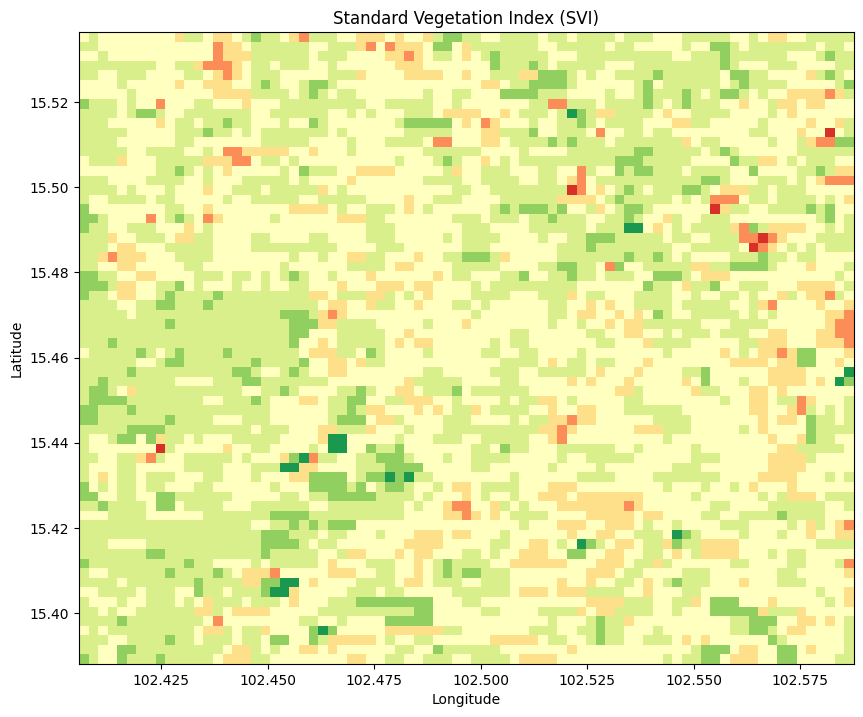

In [44]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import glob

def find_wgs84_geotiff(directory):

    # Search for all files with the '*wgs84.tif' pattern in the directory
    wgs84_files = glob.glob(os.path.join(directory, '*wgs84.tif'))

    if not wgs84_files:
        raise FileNotFoundError("No 'wgs84.tif' files found in the specified directory.")

    # Return the path to the first 'wgs84.tif' file found
    return wgs84_files[0]

def plot_svi_geotiff(svi_file_path, palette):
    # Open the SVI GeoTIFF file
    with rasterio.open(svi_file_path) as src:
        # Read the SVI data and get the metadata
        svi_data = src.read(1)
        svi_profile = src.profile

    # Define the color palette
    cmap = ListedColormap(palette)

    # Plot the SVI GeoTIFF with latitude and longitude axes
    plt.figure(figsize=(10, 10))

    # Plot the SVI data
    plt.imshow(svi_data, extent=[svi_profile['transform'][2], 
                                 svi_profile['transform'][2] + svi_profile['width'] * svi_profile['transform'][0], 
                                 svi_profile['transform'][5] + svi_profile['height'] * svi_profile['transform'][4], 
                                 svi_profile['transform'][5]], cmap=cmap)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Standard Vegetation Index (SVI)')

    plt.show()
    
if __name__ == "__main__":
    # Define the directory containing SVI GeoTIFF files
    svi_directory = 'SVI/svi_data/'

    # Find the SVI GeoTIFF file ending with 'wgs84.tif'
    svi_file_path = find_wgs84_geotiff(svi_directory)

    # Define the color palette
    palette = ['#d73027', '#fc8d59', '#fee08b', '#ffffbf', '#d9ef8b', '#91cf60', '#1a9850']

    # Plot the SVI GeoTIFF
    plot_svi_geotiff(svi_file_path, palette)


## 6. Detect Drought in Rice Fields using Satellite Data

This Python script utilizes geospatial data processing libraries such as GeoPandas and Rasterio to detect drought conditions in rice fields using satellite imagery. It calculates the mean Standard Vegetation Index (SVI) within each rice field polygon and identifies polygons where the SVI falls below a specified threshold, indicating potential drought conditions.

**Description:**

The script loads a GeoDataFrame representing rice field polygons and a GeoTIFF file containing SVI data. It iterates over each rice field polygon, masks the SVI data, calculates the mean SVI value within each polygon, and compares it to a threshold value. Rice field polygons with mean SVI values below the threshold are identified as being affected by drought. The affected polygons are visualized on a map along with the original rice field polygons for spatial reference. Additionally, the script prints out the threshold SVI value and the number of polygons affected by drought.


/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/watcharin-p/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.p

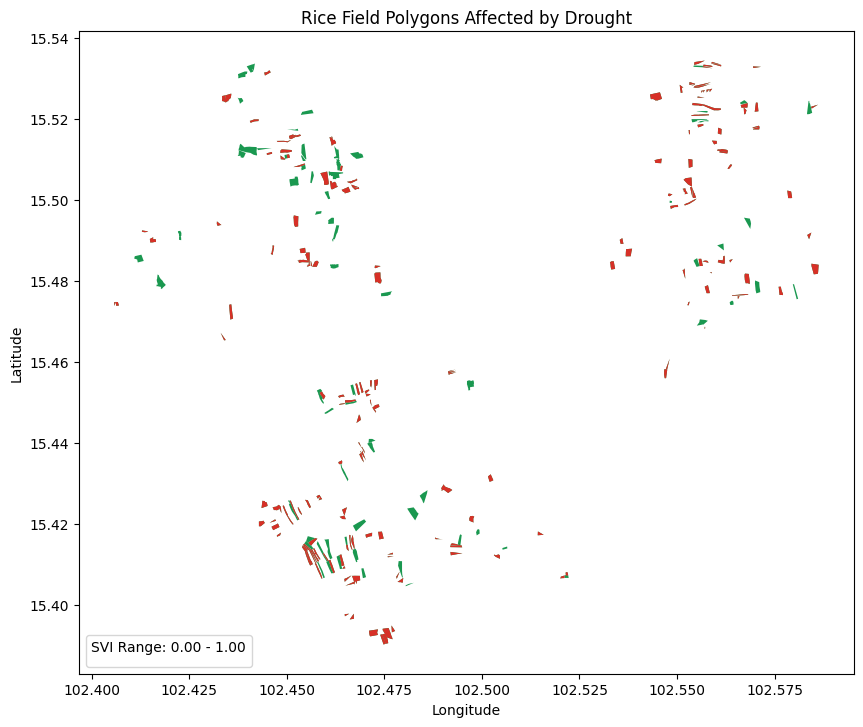

Threshold SVI value: 0.05
Number of polygons affected by drought: 180 fields


In [37]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def find_wgs84_geotiff(directory):

    # Search for all files with the '*wgs84.tif' pattern in the directory
    wgs84_files = glob.glob(os.path.join(directory, '*wgs84.tif'))

    if not wgs84_files:
        raise FileNotFoundError("No 'wgs84.tif' files found in the specified directory.")

    # Return the path to the first 'wgs84.tif' file found
    return wgs84_files[0]

def detect_drought(rice_field_data_path, svi_file_path, threshold_svi_value):
    # Load the rice field GeoDataFrame
    rice_field = gpd.read_file(rice_field_data_path)

    # Open the SVI GeoTIFF file
    with rasterio.open(svi_file_path) as src:
        svi_data = src.read(1)  # Read the SVI data
        svi_profile = src.profile  # Get the metadata/profile of the SVI data
        transform = src.transform  # Get the affine transformation parameters

        # Iterate over each polygon in the rice field GeoDataFrame
        affected_polygons = []
        for index, row in rice_field.iterrows():
            # Extract the geometry of the polygon
            geom = row['geometry']

            # Mask the SVI GeoTIFF using the polygon geometry
            out_image, out_transform = mask(src, [geom], crop=True)

            # Calculate the mean SVI value for the polygon
            mean_svi_value = np.mean(out_image)

            # Check if the mean SVI value falls below the threshold
            if mean_svi_value < threshold_svi_value:
                affected_polygons.append(row)

        # Convert the list of affected polygons to a GeoDataFrame
        affected_polygons_gdf = gpd.GeoDataFrame(affected_polygons, crs=rice_field.crs)

        # Optional: Plot the affected polygons on top of the rice field polygons
        fig, ax = plt.subplots(figsize=(10, 10))
        rice_field.plot(ax=ax, color='#1a9850')
        affected_polygons_gdf.plot(ax=ax, color='#d73027')

        # Create legend for SVI values
        min_svi_value = np.min(svi_data)
        max_svi_value = np.max(svi_data)
        legend_title = f'SVI Range: {min_svi_value:.2f} - {max_svi_value:.2f}'
        ax.legend([f'Below Threshold ({threshold_svi_value})', 'Rice Fields'], loc='lower left', title=legend_title)

        ax.set_title('Rice Field Polygons Affected by Drought')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.show()

        # Print the number of affected polygons
        print('Threshold SVI value: ' + str(threshold_svi_value))
        print(f'Number of polygons affected by drought: {len(affected_polygons_gdf)} fields')

if __name__ == "__main__":
    
    threshold_svi_value = 0.05
    rice_field_data_path = 'NAKHON RATCHASIMA_L1_2021_delgeom.geojson'
    svi_directory = 'SVI/svi_data/'
    svi_file_path = find_wgs84_geotiff(svi_directory)
    detect_drought(rice_field_data_path, svi_file_path, threshold_svi_value)
